# Chapter 6: Analyzing Topology (WIP)

In [3]:
import sys
sys.path.append("../../")

import gempy as gp

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Creating an example Model

First let's set up a simple example model. For that we initialize the geo_data object with the correct model extent and the resolution we like. Then we load our data points from csv files and set the series and order the formations (stratigraphic pile).

In [10]:
# initialize geo_data object
geo_model = gp.create_model("Model_Tutorial6")
# import data points
gp.init_data(geo_model, [0, 3000, 0, 20, 0, 2000], [50, 3, 67], 
             path_i="../input_data/tut_chapter6/ch6_data_interf.csv", 
             path_o="../input_data/tut_chapter6/ch6_data_fol.csv")

gp.map_series_to_formations(geo_model,
                                {"fault": "Fault",
                                 "Rest": ('Layer 2', 'Layer 3', 'Layer 4', 'Layer 5')}
                                )
geo_model.set_is_fault(["fault"])

../..\gempy\core\data.py:1281: UserWarning: If pole_vector and orientation are passed pole_vector is used/
  warnings.warn('If pole_vector and orientation are passed pole_vector is used/')


,isFault,isFinite
fault,True,False
Rest,False,False


And quickly have a look at the data:

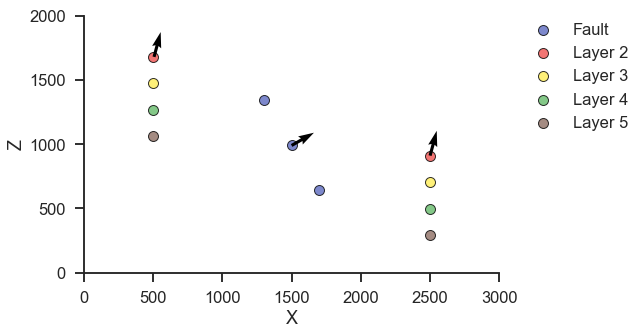

In [14]:
gp.plot.plot_data(geo_model)

Then we can compile our interpolator object and compute our model:

In [15]:
gp.set_interpolation_data(geo_model)
sol = gp.compute_model(geo_model)

Compiling theano function...
Compilation Done!


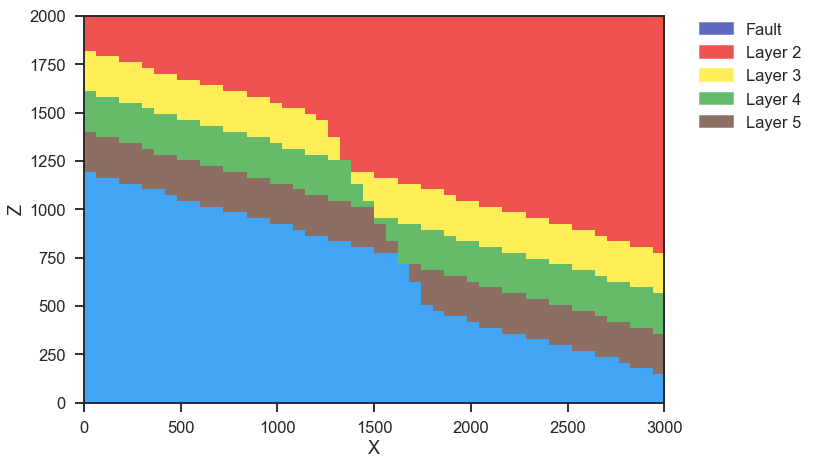

In [18]:
gp.plot.plot_section(geo_model, 0)

## Analyzing Topology

GemPy sports in-built functionality to analyze the topology of its models. All we need for this is our geo_data object, lithology block and the fault block. We input those into *gp.topology_compute* and get several useful outputs:

* an adjacency graph **G**, representing the topological relationships of the model
* the **centroids** of the all the unique topological regions in the model (x,y,z coordinates of their center) 
* a list of all the unique labels (labels_unique)
* two look-up-tables from the lithology id's to the node labels, and vice versa

In [21]:
from gempy.assets import topology as tp

In [22]:
from importlib import reload
reload(tp)

<module 'gempy.assets.topology' from '../..\\gempy\\assets\\topology.py'>

In [26]:
G, c, labels_unique, lith_to_labels_lot, labels_to_lith_lot = tp.compute_topology(geo_model)

After computing the model topology, we can overlay the topology graph over a model section:

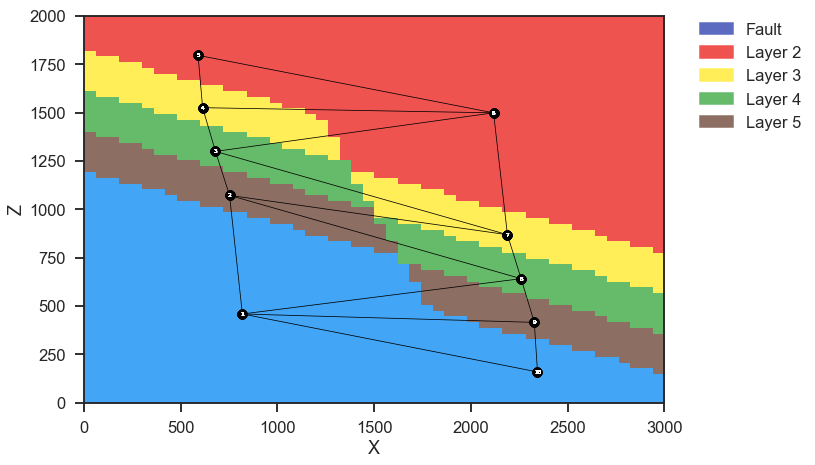

In [28]:
gp.plot.plot_section(geo_model, 2)
gp.plot.plot_topology(geo_model, G, c)

So let's say we want to check if the green layer (layer 4) is connected across the fault. For that we first need to look up which nodes belong to the layer. In this simple model we could easily do that by looking at the plot above, but we can also use the look-up-tables provided by the topology function:

In [29]:
lith_to_labels_lot["4"].keys()

dict_keys(['3', '8'])

Okay, layer 4 is represented by nodes 3 and 8. We can now put these into *topology_check_adjacency* function, which puts out *True* if the two nodes share a connection (are adjacent) and *False* if not:

In [31]:
tp.check_adjacency(G, 8, 3)

False

We can also easily look up to which other nodes a node is adjacent:

In [32]:
G.adj[8]

AtlasView({2: {'edge_type': 'fault'}, 7: {'edge_type': 'fault'}, 1: {'edge_type': 'fault'}, 9: {'edge_type': 'fault'}})

The adjacency dictionary of the graph shows that node 8 is connected to nodes 1, 2, 7 and 9. If we go one level deeper in the dictionary, we can access the type of connection (edge):

In [16]:
G.adj[8][2]["edge_type"]

'fault'

This way we can directly check if node 8 and 2 (or any other pair of nodes that share a connection) are connected across a fault, or just stratigraphically.